In [2]:
# install parity-fairness package
#pip install parity-fairness

In [1]:
## Import Libraries

# Fairness metrics and mitigation from the parity-fairness package
from parity.fairness_metrics import *
from parity.fair import *

# For Exploratory Data Analysis
import pandas_profiling
from pandas_profiling import ProfileReport

%matplotlib inline
# Data manipulation libraries
import pandas as pd
import numpy as np

# ML libraries
from sklearn.ensemble import RandomForestClassifier

# Loads Model
import joblib 

# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load Data

In [2]:
data = pd.read_csv('data/census.csv')

In [27]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


### AIF360 Dataset Standardization

In [28]:
priv_category = 'sex'
priv_value = 'Male'
target_label = 'income'
unencoded_target_label = '>50K'
cols_to_drop = ['fnlwgt', 'capital-gain', 'capital-loss']

In [29]:
data_orig_sex, encoders, numerical_features, categorical_features = prepare_data(data, priv_category, priv_value, target_label, 
                             priv_target_value=unencoded_target_label, ignore_cols=cols_to_drop)


### Sample Modelling

The main goal is to find out how we can prevent bias on our model. So I will just construct a simple Random Forest model.

In [30]:
data_orig_sex_train, data_orig_sex_test = data_orig_sex.split([0.7], shuffle=True)

In [31]:
# Train and save the models
rf_orig_sex = RandomForestClassifier().fit(data_orig_sex_train.features, 
                     data_orig_sex_train.labels.ravel(), 
                     sample_weight=data_orig_sex_train.instance_weights)

In [32]:
X_test_sex = data_orig_sex_test.features
y_test_sex = data_orig_sex_test.labels.ravel()

#### Accuracy of the model :

0.8165563365863646


#### F1 score of the model :

0.5935893559117024


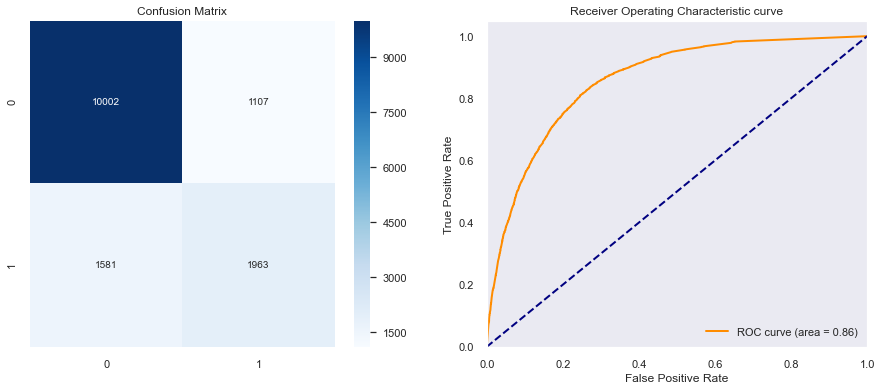

In [33]:
# Checks performance of the model
plot_model_performance(rf_orig_sex, X_test_sex, y_test_sex)

# Bias and Fairness

A common problem with most machine learning models is bias from data. This notebook shows how to measure those biases and perform bias mitigation. A python package called [aif360](https://github.com/IBM/AIF360) can give us metrics and algorithms for bias measurement and mitigation

### Metrics

* Statistical Parity Difference
* Equal Opportunity Difference
* Average Absolute Odds Difference
* Disparate Impact
* Theil Index

### Statistical Parity Difference

This measure is based on the following formula : 

$$ Pr(Y=1|D=unprivileged) - Pr(Y=1|D=privileged) $$

*Statistical imparity* is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1.

Fairer scores are close to **0**.

More documentation here [One definition of algorithmic fairness: statistical parity](https://jeremykun.com/2015/10/19/one-definition-of-algorithmic-fairness-statistical-parity/).


### Equal Opportunity Difference

This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group.

$$ TPR_{D=unprivileged} - TPR_{D=privileged} $$ 

Fairer scores are close to **0**.

### Average Absolute Odds Difference

This measure is using both false positive rate and true positive rate to calculate the bias.

$$ \frac{1}{2}[|FPR_{D=unprivileged} - FPR_{D=privileged} | + | TPR_{D=unprivileged} - TPR_{D=privileged}|]$$

Fairer scores are close to **0**.

### Disparate Impact

For this metric we use the following formula :

$$ \frac{Pr(Y=1|D=unprivileged)}{Pr(Y=1|D=privileged)} $$

Like the first metric we use both probabities of a random individual drawn from unprivileged or privileged with a label of 1 but here it's a ratio. 

Better disparate impact should be closer to **1**.

### Theil Index

This measure is also known as the generalized entropy index but with $\alpha$ equals to 1. More information here [Generalized Entropy Index](https://en.wikipedia.org/wiki/Generalized_entropy_index)).

$$ \frac{1}{n} \sum_{i=0}^{n} \frac{b_i}{\mu} ln \frac{b_i}{\mu} $$ 

Where $b_i = \hat{y}_i - y_i + 1 $

Fairer scores are close to **0**.


Some metrics need predictions while others just the original dataset. This is why we will use 2 classes of the aif360 package : `ClassificationMetric` and `BinaryLabelDatasetMetric`. 

### For `ClassificationMetric` : 
* [Equal Opportunity Difference: ](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.equal_opportunity_difference) `equal_opportunity_difference()`
* [Average Absolute Odds Difference: ](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.average_abs_odds_difference) `average_abs_odds_difference()`
* [Theil Index : ](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.theil_index) `theil_index()`

### For `BinaryLabelDatasetMetric` : 
* [Statistical Parity Difference: ](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.BinaryLabelDatasetMetric.statistical_parity_difference) `statistical_parity_difference()`
* [Disparate Impact: ](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.disparate_impact) `disparate_impact()`

In [34]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

### Display Bias

# Bias metrics for the model with protected attribute: Sex

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the sex attribute :

With default thresholds, bias against unprivileged group detected in **4** out of 5 metrics

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
sex,-0.191392,-0.114998,0.109148,0.298778,0.141116


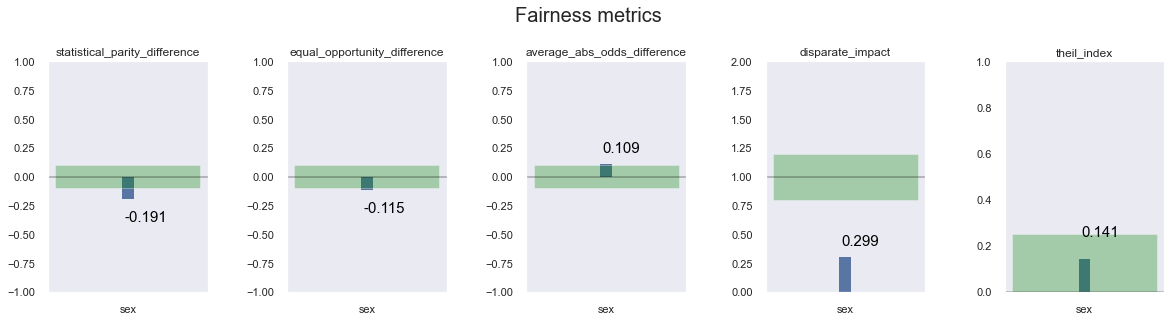

In [35]:
display(Markdown('# Bias metrics for the model with protected attribute: Sex'))
fair = get_fair_metrics_and_plot(data_orig_sex_test, rf_orig_sex)

Bias exists in the data (its close to zero) but its still nonzero.

# Bias Mitigation

There are three types of bias mitigation:
- Pre-processing algorithms : they are used before training the model
- In-processing algorithms : they are fair classifiers so it's during the training
- Post-processing algorithms : they are used after training the model

## Pre-processing Algorithms

### Disparate Impact Remover

Disparate impact remover is a preprocessing technique that edits feature values increase group fairness while preserving rank-ordering within groups. This method doesn't need predictions to fix bias.
If you want to see how it works you can take a look on [an example Notebook from the GitHub of AIF360](https://github.com/IBM/AIF360/blob/master/examples/demo_disparate_impact_remover.ipynb).

Source : [Feldman et al., 2015](https://dl.acm.org/citation.cfm?doid=2783258.2783311)

### Learning Fair Representation

Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes.
You can find more information on [the demo notebook](https://github.com/IBM/AIF360/blob/master/examples/demo_lfr.ipynb).

Source : [Zemel et al., 2013](http://proceedings.mlr.press/v28/zemel13.html)

### Reweighing

Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification.

Source : [Kamiran and Calders, 2012](https://link.springer.com/article/10.1007%2Fs10115-011-0463-8)

### Disparate Impact Remover


In [36]:
%%time
# Remove bias through disparate impact remover
data_transf_df = disparate_impact_remover(data_orig_sex_train)

# Decode to pandas dataframe for readability
decoded_df = decode_dataset(data_transf_df, encoders, numerical_features, categorical_features)
decoded_df

Wall time: 7.96 s


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
4166,54.0,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,47.0,United-States,>50K
30248,50.0,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,13.0,United-States,<=50K
17148,17.0,Private,11th,7.0,Never-married,Sales,Own-child,White,Male,24.0,United-States,<=50K
38354,30.0,Private,HS-grad,9.0,Divorced,Sales,Unmarried,White,Female,54.0,United-States,<=50K
9210,41.0,Local-gov,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,38.0,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...
37254,21.0,Private,HS-grad,9.0,Never-married,Handlers-cleaners,Own-child,White,Male,31.0,United-States,<=50K
12645,63.0,Private,Some-college,10.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,9.0,United-States,<=50K
28931,25.0,Private,HS-grad,9.0,Married-civ-spouse,Transport-moving,Husband,White,Male,34.0,United-States,>50K
13015,18.0,Private,HS-grad,9.0,Never-married,Craft-repair,Own-child,White,Male,25.0,United-States,<=50K


### Learning Fair Representation

Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes.
You can find more information on [the demo notebook](https://github.com/IBM/AIF360/blob/master/examples/demo_lfr.ipynb).

Source : [Zemel et al., 2013](http://proceedings.mlr.press/v28/zemel13.html)

In [37]:
%%time
# Remove bias through LFR
data_transf_df = learning_fair_representation(data_orig_sex_train, priv_category)

# Decode to pandas dataframe for readability
decoded_df = decode_dataset(data_transf_df, encoders, numerical_features, categorical_features)
decoded_df

4250 75757.999250678
4500 50533.45936452187
Wall time: 9.23 s


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
4166,38.617818,Never-worked,Doctorate,10.062203,Married-civ-spouse,Handlers-cleaners,Not-in-family,Other,Male,40.432398,Thailand,<=50K
30248,38.617818,Never-worked,Doctorate,10.062203,Married-civ-spouse,Handlers-cleaners,Not-in-family,Other,Male,40.432398,Thailand,<=50K
17148,38.617818,Never-worked,Doctorate,10.062203,Married-civ-spouse,Handlers-cleaners,Not-in-family,Other,Male,40.432398,Thailand,<=50K
38354,38.617818,Never-worked,Doctorate,10.062203,Married-civ-spouse,Handlers-cleaners,Not-in-family,Other,Female,40.432398,Thailand,<=50K
9210,38.617818,Never-worked,Doctorate,10.062203,Married-civ-spouse,Handlers-cleaners,Not-in-family,Other,Male,40.432398,Thailand,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
37254,38.617818,Never-worked,Doctorate,10.062203,Married-civ-spouse,Handlers-cleaners,Not-in-family,Other,Male,40.432398,Thailand,<=50K
12645,38.617818,Never-worked,Doctorate,10.062203,Married-civ-spouse,Handlers-cleaners,Not-in-family,Other,Male,40.432398,Thailand,<=50K
28931,38.617818,Never-worked,Doctorate,10.062203,Married-civ-spouse,Handlers-cleaners,Not-in-family,Other,Male,40.432398,Thailand,<=50K
13015,38.617818,Never-worked,Doctorate,10.062203,Married-civ-spouse,Handlers-cleaners,Not-in-family,Other,Male,40.432398,Thailand,<=50K


### Reweighing

Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification.

Source : [Kamiran and Calders, 2012](https://link.springer.com/article/10.1007%2Fs10115-011-0463-8)

In [38]:
%%time
# Remove bias through reweighing
data_transf_df = reweight(data_orig_sex_train, priv_category)

# Decode to pandas dataframe for readability
decoded_df = decode_dataset(data_transf_df, encoders, numerical_features, categorical_features)
decoded_df

Wall time: 237 ms


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
4166,54.0,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,55.0,United-States,>50K
30248,50.0,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,15.0,United-States,<=50K
17148,17.0,Private,11th,7.0,Never-married,Sales,Own-child,White,Male,28.0,United-States,<=50K
38354,30.0,Private,HS-grad,9.0,Divorced,Sales,Unmarried,White,Female,54.0,United-States,<=50K
9210,41.0,Local-gov,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,45.0,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...
37254,21.0,Private,HS-grad,9.0,Never-married,Handlers-cleaners,Own-child,White,Male,36.0,United-States,<=50K
12645,63.0,Private,Some-college,10.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,10.0,United-States,<=50K
28931,25.0,Private,HS-grad,9.0,Married-civ-spouse,Transport-moving,Husband,White,Male,40.0,United-States,>50K
13015,18.0,Private,HS-grad,9.0,Never-married,Craft-repair,Own-child,White,Male,30.0,United-States,<=50K


## In-process Algorithms

### Prejudice Remover Regularizer

Prejudice remover is an in-processing technique that adds a discrimination-aware regularization term to the learning objective.

Source : [Kamishima et al., 2012](https://rd.springer.com/chapter/10.1007/978-3-642-33486-3_3)

In [39]:
%%time
data_transf_train_df, data_transf_test_df = prejudice_remover(data_orig_sex_train, data_orig_sex_test, priv_category, eta=25)

Wall time: 7min 35s


In [40]:
# Decode to pandas dataframe using encoders from preprocessed data
decoded_train_df = decode_dataset(data_transf_train_df, encoders, numerical_features, categorical_features)
decoded_train_df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
4166,54.0,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,55.0,United-States,>50K
30248,50.0,Private,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,15.0,United-States,<=50K
17148,17.0,Private,11th,7.0,Never-married,Sales,Own-child,White,Male,28.0,United-States,<=50K
38354,30.0,Private,HS-grad,9.0,Divorced,Sales,Unmarried,White,Female,54.0,United-States,<=50K
9210,41.0,Local-gov,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,45.0,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...
37254,21.0,Private,HS-grad,9.0,Never-married,Handlers-cleaners,Own-child,White,Male,36.0,United-States,<=50K
12645,63.0,Private,Some-college,10.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,10.0,United-States,<=50K
28931,25.0,Private,HS-grad,9.0,Married-civ-spouse,Transport-moving,Husband,White,Male,40.0,United-States,<=50K
13015,18.0,Private,HS-grad,9.0,Never-married,Craft-repair,Own-child,White,Male,30.0,United-States,<=50K


In [41]:
# Decode to pandas dataframe using encoders from preprocessed data
decoded_test_df = decode_dataset(data_transf_test_df, encoders, numerical_features, categorical_features)
decoded_test_df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
18046,49.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,20.0,United-States,>50K
28211,26.0,Private,Some-college,10.0,Married-civ-spouse,Transport-moving,Husband,White,Male,52.0,United-States,<=50K
21500,51.0,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,35.0,Taiwan,<=50K
27822,63.0,Local-gov,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,40.0,United-States,>50K
4169,26.0,Private,Bachelors,13.0,Never-married,Sales,Own-child,White,Male,45.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
12069,35.0,Private,HS-grad,9.0,Never-married,Machine-op-inspct,Own-child,White,Male,40.0,United-States,<=50K
36567,39.0,Private,HS-grad,9.0,Divorced,Transport-moving,Not-in-family,White,Male,40.0,United-States,<=50K
25616,38.0,Private,Assoc-voc,11.0,Never-married,Craft-repair,Own-child,White,Male,40.0,United-States,<=50K
1984,32.0,Self-emp-inc,11th,7.0,Married-civ-spouse,Craft-repair,Husband,White,Male,40.0,United-States,<=50K


## Post-processing algorithms

### Calibrated Equality of Odds

Calibrated equalized odds postprocessing is a post-processing technique that optimizes over calibrated classifier score outputs to find probabilities with which to change output labels with an equalized odds objective.

Source : [Pleiss et al., 2017](https://papers.nips.cc/paper/7151-on-fairness-and-calibration)

### Reject Option Classification

Reject option classification is a postprocessing technique that gives favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty.

Source : [Kamishima et al., 2012](https://ieeexplore.ieee.org/document/6413831/)

In [42]:
data_orig_test = data_orig_sex_test
data_orig_train = data_orig_sex_train
rf = rf_orig_sex

probs = rf.predict_proba(data_orig_test.features)
preds = rf.predict(data_orig_test.features)
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, preds, probs, 'Origin')

In [43]:
data_orig_test_pred = data_orig_test.copy(deepcopy=True)

# Prediction with the original RandomForest model
scores = np.zeros_like(data_orig_test.labels)
scores = rf.predict_proba(data_orig_test.features)[:,1].reshape(-1,1)
data_orig_test_pred.scores = scores

preds = np.zeros_like(data_orig_test.labels)
preds = rf.predict(data_orig_test.features).reshape(-1,1)
data_orig_test_pred.labels = preds

def format_probs(probs1):
    probs1 = np.array(probs1)
    probs0 = np.array(1-probs1)
    return np.concatenate((probs0, probs1), axis=1)

### Calibrated Equality of Odds

Calibrated equalized odds postprocessing is a post-processing technique that optimizes over calibrated classifier score outputs to find probabilities with which to change output labels with an equalized odds objective.

Source : [Pleiss et al., 2017](https://papers.nips.cc/paper/7151-on-fairness-and-calibration)

In [44]:
%%time
data_trans_pred = calibrate_equality_of_odds(data_orig_train, data_orig_test, data_orig_test_pred, priv_category)
data_trans_pred

Wall time: 765 ms


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
18046,0.438356,4.0,9.0,0.800000,2.0,10.0,5.0,4.0,0.0,0.193878,39.0,1.0
28211,0.123288,4.0,15.0,0.600000,2.0,14.0,0.0,4.0,1.0,0.520408,39.0,0.0
21500,0.465753,5.0,9.0,0.800000,2.0,4.0,5.0,1.0,0.0,0.346939,36.0,1.0
27822,0.630137,2.0,9.0,0.800000,2.0,10.0,0.0,4.0,1.0,0.397959,39.0,1.0
4169,0.123288,4.0,9.0,0.800000,4.0,12.0,3.0,4.0,1.0,0.448980,39.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12069,0.246575,4.0,11.0,0.533333,4.0,7.0,3.0,4.0,1.0,0.397959,39.0,0.0
36567,0.301370,4.0,11.0,0.533333,0.0,14.0,1.0,4.0,1.0,0.397959,39.0,0.0
25616,0.287671,4.0,8.0,0.666667,4.0,3.0,3.0,4.0,1.0,0.397959,39.0,0.0
1984,0.205479,5.0,1.0,0.400000,2.0,3.0,0.0,4.0,1.0,0.397959,39.0,0.0


In [45]:
%%time
# Decode to pandas dataframe using encoders from preprocessed data
decoded_pred_df = decode_dataset(data_trans_pred, encoders, numerical_features, categorical_features)
decoded_pred_df

Wall time: 522 ms


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
18046,49.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,20.0,United-States,>50K
28211,26.0,Private,Some-college,10.0,Married-civ-spouse,Transport-moving,Husband,White,Male,52.0,United-States,<=50K
21500,51.0,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,35.0,Taiwan,>50K
27822,63.0,Local-gov,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,40.0,United-States,>50K
4169,26.0,Private,Bachelors,13.0,Never-married,Sales,Own-child,White,Male,45.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
12069,35.0,Private,HS-grad,9.0,Never-married,Machine-op-inspct,Own-child,White,Male,40.0,United-States,<=50K
36567,39.0,Private,HS-grad,9.0,Divorced,Transport-moving,Not-in-family,White,Male,40.0,United-States,<=50K
25616,38.0,Private,Assoc-voc,11.0,Never-married,Craft-repair,Own-child,White,Male,40.0,United-States,<=50K
1984,32.0,Self-emp-inc,11th,7.0,Married-civ-spouse,Craft-repair,Husband,White,Male,40.0,United-States,<=50K


### Reject Option Classification

Reject option classification is a postprocessing technique that gives favorable outcomes to unpriviliged groups and unfavorable outcomes to priviliged groups in a confidence band around the decision boundary with the highest uncertainty.

Source : [Kamishima et al., 2012](https://ieeexplore.ieee.org/document/6413831/)

In [46]:
data_trans_pred = reject_option(data_orig_train, data_orig_test, data_orig_test_pred, priv_category)
data_trans_pred

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
18046,0.438356,4.0,9.0,0.800000,2.0,10.0,5.0,4.0,0.0,0.193878,39.0,1.0
28211,0.123288,4.0,15.0,0.600000,2.0,14.0,0.0,4.0,1.0,0.520408,39.0,1.0
21500,0.465753,5.0,9.0,0.800000,2.0,4.0,5.0,1.0,0.0,0.346939,36.0,1.0
27822,0.630137,2.0,9.0,0.800000,2.0,10.0,0.0,4.0,1.0,0.397959,39.0,1.0
4169,0.123288,4.0,9.0,0.800000,4.0,12.0,3.0,4.0,1.0,0.448980,39.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12069,0.246575,4.0,11.0,0.533333,4.0,7.0,3.0,4.0,1.0,0.397959,39.0,0.0
36567,0.301370,4.0,11.0,0.533333,0.0,14.0,1.0,4.0,1.0,0.397959,39.0,0.0
25616,0.287671,4.0,8.0,0.666667,4.0,3.0,3.0,4.0,1.0,0.397959,39.0,0.0
1984,0.205479,5.0,1.0,0.400000,2.0,3.0,0.0,4.0,1.0,0.397959,39.0,1.0


In [47]:
# Decode to pandas dataframe using encoders from preprocessed data
decoded_pred_df = decode_dataset(data_trans_pred, encoders, numerical_features, categorical_features)
decoded_pred_df

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
18046,49.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,20.0,United-States,>50K
28211,26.0,Private,Some-college,10.0,Married-civ-spouse,Transport-moving,Husband,White,Male,52.0,United-States,>50K
21500,51.0,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,35.0,Taiwan,>50K
27822,63.0,Local-gov,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,40.0,United-States,>50K
4169,26.0,Private,Bachelors,13.0,Never-married,Sales,Own-child,White,Male,45.0,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
12069,35.0,Private,HS-grad,9.0,Never-married,Machine-op-inspct,Own-child,White,Male,40.0,United-States,<=50K
36567,39.0,Private,HS-grad,9.0,Divorced,Transport-moving,Not-in-family,White,Male,40.0,United-States,<=50K
25616,38.0,Private,Assoc-voc,11.0,Never-married,Craft-repair,Own-child,White,Male,40.0,United-States,<=50K
1984,32.0,Self-emp-inc,11th,7.0,Married-civ-spouse,Craft-repair,Husband,White,Male,40.0,United-States,>50K
